<a href="https://colab.research.google.com/github/lachyjung/DACON_-/blob/master/KAERI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import Module
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
print(device)

cpu


In [ ]:
'''train_data = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_features.csv')

test_data = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_target.csv')'''

"train_data = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_features.csv')\n\ntest_data = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_target.csv')"

In [ ]:
#train_data.iloc[:,2:].tail(10)

In [ ]:
#test_data.iloc[:,1:].tail(10)

In [ ]:
'''train_data.info()
test_data.info()'''

'train_data.info()\ntest_data.info()'

In [ ]:
"""index_for_batch = train_data.id
count=index_for_batch.value_counts()
count.unique()"""

'index_for_batch = train_data.id\ncount=index_for_batch.value_counts()\ncount.unique()'

In [ ]:
class my_train_dataset(Dataset):
  def __init__(self):
    #set_window
    self.window = 375

    #train_feature_data
    self.train_features = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_features.csv')
    self.train_features = self.train_features.iloc[:,2:]

    #normalize with min-max
    self.max_feature = self.train_features.max().max()
    self.min_feature = self.train_features.min().min()
    self.div_feature = self.max_feature - self.min_feature
    self.train_features = np.divide((self.train_features-self.min_feature),self.div_feature)
    

    self.train_features = torch.from_numpy(np.array(self.train_features)).float()
    self.train_features, self.val_features = torch.utils.data.random_split(self.train_features, [1900*self.window, 900*self.window])


    #train_target_data
    self.train_target = pd.read_csv('/content/drive/My Drive/충돌체/KAERI_dataset/train_target.csv')
    self.train_target = self.train_target.iloc[:,1:]

    #normalize with (train_features)min-max
    self.train_target = np.divide((self.train_target-self.min_feature),self.div_feature)

    self.train_target = torch.from_numpy(np.array(self.train_target)).float()
    self.train_target, self.val_target = torch.utils.data.random_split(self.train_target, [1900, 900])

   

  def __getitem__(self, index):
    return self.train_features[(self.window * index): (self.window * index)+ self.window], self.train_target[index]

  def __len__(self):
    return len(self.train_target)


In [ ]:
class my_val_dataset(my_train_dataset):

  def __getitem__(self, index):
    return self.val_features[(self.window * index): (self.window * index)+ self.window], self.val_target[index]

  def __len__(self):
    #put side 300 data for test
    return len(self.val_target)-300

In [ ]:
feed_data = my_train_dataset()
train_loader = DataLoader(dataset=feed_data, batch_size = 20, shuffle=False)

val_data = my_val_dataset()
val_loader = DataLoader(dataset=val_data, batch_size = 20, shuffle=False)

In [ ]:
print(next(iter(train_loader))[0].shape[0])

20


In [ ]:
class myModel(Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(myModel,self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, 1,batch_first=True)
    self.fc_1 = nn.Linear(hidden_dim, 50, bias=True)
    self.fc_2= nn.Linear(50,20, bias=True)
    self.output = nn.Linear(20, output_dim, bias=True)
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.hidden_dim = hidden_dim
  

  def forward(self, inputs):
    lstm_out, hidden_cell = self.lstm(inputs, (torch.zeros(1,inputs.shape[0] ,self.hidden_dim), torch.zeros(1,inputs.shape[0] ,self.hidden_dim)))
    layer_1 = self.dropout(self.relu(self.fc_1(hidden_cell[0])))
    layer_2 = self.dropout(self.relu(self.fc_2(layer_1)))
    prediction = self.output(layer_2)
    return prediction


In [ ]:
model = myModel(4,20,4)

In [ ]:
print(model.state_dict().keys())

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'fc_1.weight', 'fc_1.bias', 'fc_2.weight', 'fc_2.bias', 'output.weight', 'output.bias'])


In [ ]:

with torch.autograd.set_detect_anomaly(True):
  model = myModel(4,20,4)
  #model = model.to(device)
  
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  train_history = []
  val_history=[]


  for epoch in range(1000):
    if (len(val_history)>10) and  (val_history[-3] < val_history[-1]):
      
      print(f'train_terminated in epoch{epoch-1} & model_saved')
      break
    
    else:

      model.train()
      for i, data in enumerate(train_loader, 0):
        feat, targ = data
        #feat, targ = feat.to(device), targ.to(device)
        y_pred = model(feat)
        
        loss = criterion(y_pred[0], targ)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

        if i % 10 == 0:
          print(f'epoch:{epoch} <{i}> iter:{int((i/(1900/20))*100)}%   loss:{loss.item()}' )
       
      train_history.append(loss.item()) 
      torch.save(model.state_dict(), '/content/drive/My Drive/충돌체/model_history/best_model.pth') 
        
      model.eval()
      temp = []
      for val_feat, val_targ in val_loader:
          #val_feat, val_targ = val_feat.to(device), val_targ.to(device)
              
          val_pred = model(val_feat)
          val_loss = criterion(val_pred[0], val_targ)
          temp.append(val_loss.item())
      val_history.append(np.array(temp).mean())
      del(temp)
        
      print(f'***********   epoch:{epoch}  val_loss:{val_history[-1]}***********' )



epoch:0 <0> iter:0%   loss:0.4237394332885742
epoch:0 <10> iter:10%   loss:0.3394143879413605
epoch:0 <20> iter:21%   loss:0.261219322681427
epoch:0 <30> iter:31%   loss:0.20873360335826874
epoch:0 <40> iter:42%   loss:0.14814843237400055
epoch:0 <50> iter:52%   loss:0.11711053550243378
epoch:0 <60> iter:63%   loss:0.09490682184696198
epoch:0 <70> iter:73%   loss:0.06727127730846405
epoch:0 <80> iter:84%   loss:0.05217136815190315
epoch:0 <90> iter:94%   loss:0.047667041420936584
***********   epoch:0  val_loss:0.026048645563423633***********
epoch:1 <0> iter:0%   loss:0.034408602863550186
epoch:1 <10> iter:10%   loss:0.028701409697532654
epoch:1 <20> iter:21%   loss:0.029278546571731567
epoch:1 <30> iter:31%   loss:0.03206833079457283
epoch:1 <40> iter:42%   loss:0.018624598160386086
epoch:1 <50> iter:52%   loss:0.012935502454638481
epoch:1 <60> iter:63%   loss:0.018366167321801186
epoch:1 <70> iter:73%   loss:0.020213229581713676
epoch:1 <80> iter:84%   loss:0.019260704517364502
epoc

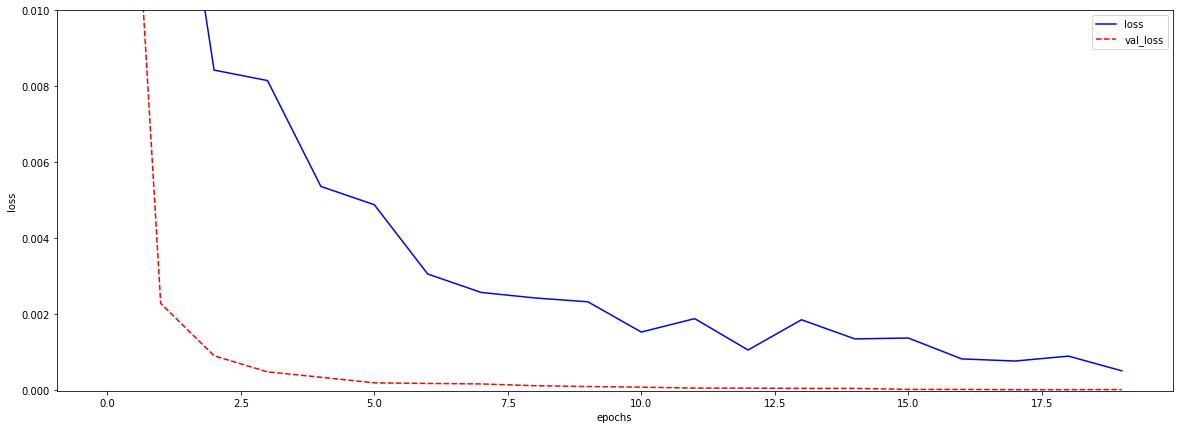

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(len(train_history)), train_history, 'b-', label='loss')
plt.plot(range(len(val_history)), val_history, 'r--', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(-0.00001,0.01)
plt.savefig('/content/drive/My Drive/충돌체/model_history/loss_plt.png', format='png')
plt.show()

In [ ]:
#dynamic batch size

In [ ]:
#the_model = TheModelClass(*args, **kwargs), the_model.load_state_dict(torch.load(PATH))
#callback_function
#gpu
#model_extention
#batch_normalization
#intialization
#save_model(model.state_dic)
#loss_function